In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [178]:
from sklearn import datasets, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, RidgeCV, LassoCV,ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix

## Importing Data

In [4]:
#importing data: distances from floods to land/water boundary
fl_1 = pd.read_csv('data/flood-outline-distances.csv')

In [5]:
#importing data: altitude, slope, rain, land cover of flood centroids
fl_2 = pd.read_csv('data/point-data.csv')

In [52]:
#importing data: altitude and slope at random points
pt_1 = pd.read_csv('data/slope_alt_point-data.csv')

In [8]:
#importing data: rain, land cover, distances to land/water boundary and to nearest flood
pt_2 = pd.read_csv('data/points-minus-dem.csv')

In [9]:
#merging flooding data
fl = pd.merge(fl_1, fl_2, how = 'left', on = 'rec_out_id')

In [53]:
pt_1['fid'] = pt_1['rand_point_id']+1

In [54]:
#merging random point data
pt = pd.merge(pt_1, pt_2, how = 'left', on = 'fid')

## Cleaning data

In [11]:
fl.columns

Index(['fid_x', 'rec_out_id', 'rec_grp_id_x', 'name_x', 'start_date_x',
       'end_date_x', 'flood_src_x', 'flood_caus_x', 'fm_status_x',
       'hfm_status_x', 'data_src_x', 'fluvial_f_x', 'coastal_f_x', 'tidal_f_x',
       'data_prov_x', 'data_qual_x', 'st_area_sh_x', 'st_perimet_x',
       'join_fid', 'join_gml_id', 'join_propertyValue',
       'join_propertyValue_uom', 'join_waterLevelCategory', 'join_layer',
       'join_path', 'distance', 'fid_y', 'rec_grp_id_y', 'name_y',
       'start_date_y', 'end_date_y', 'flood_src_y', 'flood_caus_y',
       'fm_status_y', 'hfm_status_y', 'data_src_y', 'fluvial_f_y',
       'coastal_f_y', 'tidal_f_y', 'data_prov_y', 'data_qual_y',
       'st_area_sh_y', 'st_perimet_y', 'slope-merg', 'rain-avera', 'LCM_1',
       'dem-merged'],
      dtype='object')

In [18]:
fl = fl[['rec_out_id','rec_grp_id_x', 'name_x', 'start_date_x',
       'end_date_x', 'flood_src_x', 'flood_caus_x', 
        'data_src_x', 'fluvial_f_x', 'coastal_f_x', 'tidal_f_x',
       'data_prov_x', 'data_qual_x', 'st_area_sh_x', 'st_perimet_x','distance',
        'slope-merg', 'rain-avera', 'LCM_1',
       'dem-merged']]

In [19]:
columns = {'rec_out_id':'indv_id','rec_grp_id_x':'group_id', 'name_x':'name', 'start_date_x':'start_date',
       'end_date_x':'end_date', 'flood_src_x':'flood_source', 'flood_caus_x':'flood_cause',
        'data_src_x':'data_source', 'fluvial_f_x':'fluvial', 'coastal_f_x':'coastal', 'tidal_f_x':'tidal',
       'data_prov_x':'data_prov', 'data_qual_x':'data_qual', 'st_area_sh_x':'area', 'st_perimet_x':'perimeter',
        'slope-merg':'slope', 'rain-avera':'rain', 'LCM_1':'land_cover','dem-merged':'altitude'}

In [21]:
fl.rename(columns = columns, inplace = True)

/Users/henryhodgson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


## Modelling

In [37]:
flood_points = fl.groupby('group_id').agg({'distance':'min', 'slope':'mean','rain':'mean',
                                           'altitude':'mean','land_cover':'first'}).round(decimals = 1)

In [70]:
flood_points['flooded'] = 1

In [71]:
flood_points.head()

,distance,slope,rain,altitude,land_cover,flooded
group_id,,,,,,
1741,0.0,1.5,683.4,3.6,20,1
1767,14018.7,2.1,741.2,33.9,21,1
1771,0.0,0.5,653.1,2.2,4,1
2005,0.0,1.4,751.3,32.9,21,1
2135,0.0,1.0,635.3,3.2,20,1


In [72]:
ff = flood_points.copy()

In [73]:
ff.head()

,distance,slope,rain,altitude,land_cover,flooded
group_id,,,,,,
1741,0.0,1.5,683.4,3.6,20,1
1767,14018.7,2.1,741.2,33.9,21,1
1771,0.0,0.5,653.1,2.2,4,1
2005,0.0,1.4,751.3,32.9,21,1
2135,0.0,1.0,635.3,3.2,20,1


In [74]:
ff.shape

(77, 6)

In [81]:
ff.land_cover.value_counts()

4     32
21    16
20    13
3     11
14     2
16     2
1      1
Name: land_cover, dtype: int64

In [56]:
pt.columns

Index(['rand_point_id', 'id', 'altitude', 'slope', 'rainfall', 'land_cover',
       'distance_x', 'SAMPLE_1', 'slope1', 'fid', 'ra1', 'lc1', 'lc2', 'lc3',
       'join_rec_out_id', 'join_rec_grp_id', 'join_name', 'join_start_date',
       'join_end_date', 'join_flood_src', 'join_flood_caus', 'join_fm_status',
       'join_hfm_status', 'join_data_src', 'join_fluvial_f', 'join_coastal_f',
       'join_tidal_f', 'join_data_prov', 'join_data_qual', 'join_st_area_sh',
       'join_st_perimet', 'distance_y', 'join_fid', 'join_gml_id',
       'join_propertyValue', 'join_propertyValue_uom',
       'join_waterLevelCategory', 'join_layer', 'join_path', 'water'],
      dtype='object')

In [57]:
pt = pt[['SAMPLE_1','slope1','ra1','lc1','distance_y','water']]

In [58]:
columns = {'SAMPLE_1':'altitude','slope1':'slope','ra1':'rain','lc1':'land_cover',
           'distance_y':'distance_to_flood','water':'distance'}

In [59]:
pt.rename(columns = columns, inplace = True)

/Users/henryhodgson/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [64]:
pt = pt[pt.slope > 0]

In [84]:
pt = pt[pt.land_cover != 13]

In [66]:
pt['flooded'] = [1 if x == 0 else 0 for x in pt['distance_to_flood']]

<ipython-input-66-8cf563e4ad27>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pt['flooded'] = [1 if x == 0 else 0 for x in pt['distance_to_flood']]


In [85]:
pt

,altitude,slope,rain,land_cover,distance_to_flood,distance,flooded
0,93.400002,5.015244,970.773499,4.0,4774.497798,13668.088618,0
1,8.000000,0.747003,732.576294,20.0,4790.292671,94.625874,0
2,72.199997,7.539700,905.587463,3.0,210.759472,22706.424121,0
3,44.099998,5.951367,951.245483,4.0,507.433194,13879.989621,0
4,69.099998,1.553224,970.773499,4.0,1544.300051,12502.086186,0
...,...,...,...,...,...,...,...
2995,5.200000,1.177538,693.621216,3.0,34.837183,1445.494383,0
2996,16.700001,0.444726,693.253845,3.0,793.912746,5773.455800,0
2997,24.100000,0.598163,793.041565,21.0,1536.008747,2872.213888,0
2998,73.300003,0.563187,781.301575,3.0,4963.443751,4435.742019,0


In [75]:
pt.flooded.sum()

261

Roughly 10% of random point data falls in flooded regions.

In [140]:
df = pt.copy()

In [141]:
df.drop('distance_to_flood',axis=1, inplace = True)

In [142]:
df = df.round(decimals = 1)

In [143]:
df['land_cover'] = df.land_cover.astype('object')

In [144]:
df.dtypes

altitude      float64
slope         float64
rain          float64
land_cover     object
distance      float64
flooded         int64
dtype: object

In [145]:
df = pd.get_dummies(df)

In [146]:
df.dropna(inplace=True)

In [147]:
y = df.pop('flooded')
X = df

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                        stratify=y, test_size=0.3, random_state=1)

In [149]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

## Log Reg - 92.5

In [150]:
model = LogisticRegression(solver='liblinear')

In [151]:
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [153]:
model.score(X_train, y_train)

0.9231935320869126

In [154]:
y.value_counts(normalize = True)

0    0.910537
1    0.089463
Name: flooded, dtype: float64

In [156]:
knn = KNeighborsClassifier()

In [157]:
knn.fit(X_train, y_train)
knn.score(X_train, y_train)

0.9550277918140475

In [158]:
knn.score(X_test, y_test)

0.9399293286219081

In [159]:
params = {'C': np.logspace(-5, 5, 15),
          'penalty': ['l1', 'l2'],
          'fit_intercept': [True, False]}

In [160]:
gs = GridSearchCV(estimator=model,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-2,
                  verbose=1)

In [161]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'), n_jobs=-2,
             param_grid={'C': array([1.00000000e-05, 5.17947468e-05, 2.68269580e-04, 1.38949549e-03,
       7.19685673e-03, 3.72759372e-02, 1.93069773e-01, 1.00000000e+00,
       5.17947468e+00, 2.68269580e+01, 1.38949549e+02, 7.19685673e+02,
       3.72759372e+03, 1.93069773e+04, 1.00000000e+05]),
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy', verbose=1)

In [162]:
gs_best = gs.best_estimator_
gs_best

LogisticRegression(C=5.1794746792312125, penalty='l1', solver='liblinear')

In [163]:
print(gs.best_score_)

0.9216813706687125


In [164]:
gs.score(X_train, y_train)

0.9236988377968671

In [165]:
gs.score(X_test, y_test)

0.9246171967020024

## kNN - 93.8

In [203]:
params = {'n_neighbors': [5,6,7,8,9,10],
         'weights':['uniform', 'distance']
         }

In [204]:
gs = GridSearchCV(estimator=knn,
                  param_grid=params,
                  cv=5,
                  scoring='accuracy',
                  n_jobs=-2,
                  verbose=1)

In [205]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-2,
             param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10],
                         'weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [206]:
gs_best = gs.best_estimator_
gs_best

KNeighborsClassifier(n_neighbors=8, weights='distance')

In [207]:
gs.best_params_

{'n_neighbors': 8, 'weights': 'distance'}

In [208]:
print(gs.best_score_)

0.9393658099987213


In [209]:
gs.score(X_train, y_train)

1.0

In [210]:
gs.score(X_test, y_test)

0.9422850412249706

## Undersampling

In [173]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as imb_make_pipeline

In [174]:
sampler = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())

0    177
1    177
Name: flooded, dtype: int64


In [176]:
def fitter(model, X_train, y_train, X_test, y_test, cv_score=True):
    """
    Takes a model, training and test sets as inputs and evaluated the model on both 
    reporting scores, confusion matrix and classification report.
    """

    print(model.score(X_train, y_train))
    if cv_score:
        print(cross_val_score(model, X_train, y_train, cv=5).mean())
    print(model.score(X_test, y_test))
    print()
    print(confusion_matrix(y_train, model.predict(X_train)))
    print()
    print(classification_report(y_train, model.predict(X_train)))
    print()
    print(confusion_matrix(y_test, model.predict(X_test)))
    print()
    print(classification_report(y_test, model.predict(X_test)))

In [179]:
pipe = imb_make_pipeline(RandomUnderSampler(random_state=1),
                         LogisticRegression(max_iter=10000))

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)


fitter(pipe, X_train, y_train, X_test, y_test)

0.7781707933299646
0.7902940800409155
0.7585394581861012

[[1375  427]
 [  12  165]]

              precision    recall  f1-score   support

           0       0.99      0.76      0.86      1802
           1       0.28      0.93      0.43       177

    accuracy                           0.78      1979
   macro avg       0.64      0.85      0.65      1979
weighted avg       0.93      0.78      0.82      1979


[[572 201]
 [  4  72]]

              precision    recall  f1-score   support

           0       0.99      0.74      0.85       773
           1       0.26      0.95      0.41        76

    accuracy                           0.76       849
   macro avg       0.63      0.84      0.63       849
weighted avg       0.93      0.76      0.81       849



In [212]:
sampler = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())

0    177
1    177
Name: flooded, dtype: int64


In [213]:
#with knn classifier
pipe = imb_make_pipeline(RandomUnderSampler(random_state=1),
                         KNeighborsClassifier(n_neighbors = 8))

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)


fitter(pipe, X_train, y_train, X_test, y_test)

0.8160687215765539
0.8069620253164557
0.800942285041225

[[1456  346]
 [  18  159]]

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      1802
           1       0.31      0.90      0.47       177

    accuracy                           0.82      1979
   macro avg       0.65      0.85      0.68      1979
weighted avg       0.93      0.82      0.85      1979


[[612 161]
 [  8  68]]

              precision    recall  f1-score   support

           0       0.99      0.79      0.88       773
           1       0.30      0.89      0.45        76

    accuracy                           0.80       849
   macro avg       0.64      0.84      0.66       849
weighted avg       0.93      0.80      0.84       849



## Oversampling

In [185]:
from imblearn.over_sampling import RandomOverSampler

In [186]:
sampler = RandomOverSampler(random_state=1)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

print(pd.Series(y_resampled).value_counts())

0    1802
1    1802
Name: flooded, dtype: int64


In [187]:
pipe = imb_make_pipeline(RandomOverSampler(random_state=1),
                         LogisticRegression(max_iter=10000))

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)


fitter(pipe, X_train, y_train, X_test, y_test)
model_params = {'logisticregression__penalty': ['l2'],
                'logisticregression__C': np.logspace(-2, 2, 5)
                }
gs = GridSearchCV(pipe, model_params, cv=5, n_jobs=-2)
gs.fit(X_train, y_train)
print(gs.best_score_)
fitter(gs, X_train, y_train, X_test, y_test, cv_score=False)

0.8054573016675088
0.8039355581127733
0.7915194346289752

[[1433  369]
 [  16  161]]

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      1802
           1       0.30      0.91      0.46       177

    accuracy                           0.81      1979
   macro avg       0.65      0.85      0.67      1979
weighted avg       0.93      0.81      0.84      1979


[[601 172]
 [  5  71]]

              precision    recall  f1-score   support

           0       0.99      0.78      0.87       773
           1       0.29      0.93      0.45        76

    accuracy                           0.79       849
   macro avg       0.64      0.86      0.66       849
weighted avg       0.93      0.79      0.83       849

0.80696713975195
0.8054573016675088
0.7950530035335689

[[1434  368]
 [  17  160]]

              precision    recall  f1-score   support

           0       0.99      0.80      0.88      1802
           1       0.30      0.90      0.4

<AxesSubplot:ylabel='0'>

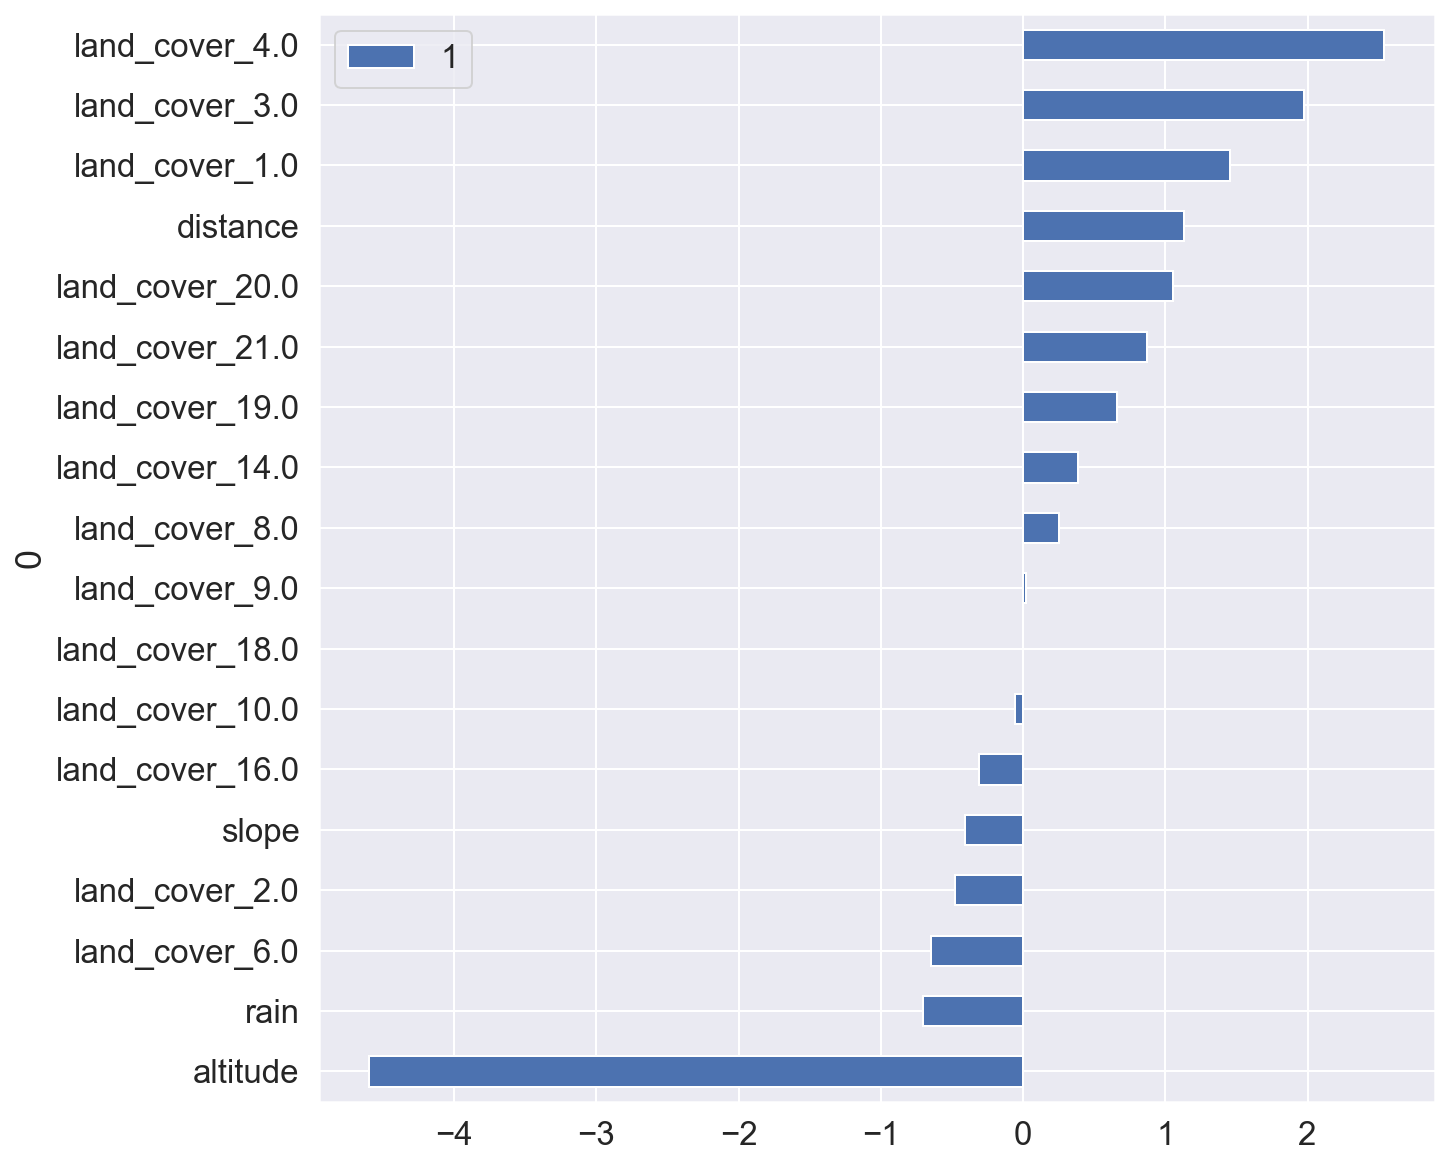

In [188]:
pd.DataFrame(list(zip(X_train.columns, list(gs.best_estimator_.steps[1][1].coef_[0])))
             ).set_index(0).sort_values(1
                                        ).plot(kind='barh', figsize=(10, 10))

In [215]:
pipe = imb_make_pipeline(RandomOverSampler(random_state=1),
                         KNeighborsClassifier(n_neighbors = 8))

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)


fitter(pipe, X_train, y_train, X_test, y_test)


0.9191510864072764
0.8772049610024293
0.8775029446407538

[[1642  160]
 [   0  177]]

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1802
           1       0.53      1.00      0.69       177

    accuracy                           0.92      1979
   macro avg       0.76      0.96      0.82      1979
weighted avg       0.96      0.92      0.93      1979


[[684  89]
 [ 15  61]]

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       773
           1       0.41      0.80      0.54        76

    accuracy                           0.88       849
   macro avg       0.69      0.84      0.73       849
weighted avg       0.93      0.88      0.89       849



## Random forest

In [223]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score

In [221]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1)
model = DecisionTreeRegressor(max_depth=3, random_state=1)

In [217]:
def do_cross_val(model, X, y, cv=5):
    scores = cross_val_score(model, X, y, cv=cv, n_jobs=-2,
                             scoring='neg_mean_squared_error')
    # , scores.std()#, cross_val_score(model, X, y, cv=cv, n_jobs=1).mean()
    return -scores.mean()

In [218]:
values = sorted(
    list(set(np.logspace(0, 3, num=20, endpoint=True, base=10.0).astype(int))))

In [228]:
score_list = []
for n in values:
    models = [('Bagging', BaggingClassifier(random_state=1, n_estimators=n, max_features=1.0)),
              ('RandomForest', RandomForestClassifier(
                  random_state=1, n_estimators=n, max_features=1.0))
              ]
    for model in models:
        model[1].fit(X_train, y_train)
        train_score_cv = do_cross_val(model[1], X_train, y_train, cv=kf)
        train_predictions = model[1].predict(X_train)
        test_predictions = model[1].predict(X_test)
        train_score = model[1].score(X_test, y_test)
        test_score = model[1].score(X_train, y_train)
        score_list.append(
            [model[0], n, train_score_cv, train_score, test_score])

In [229]:
score_list

[['Bagging', 1, 0.07882623705408516, 0.9246171967020024, 0.9742294087923193],
 ['RandomForest',
  1,
  0.07832118654903467,
  0.9199057714958775,
  0.9737241030823648],
 ['Bagging', 2, 0.07427311085538933, 0.9328621908127208, 0.9752400202122284],
 ['RandomForest',
  2,
  0.07073392149341517,
  0.9293286219081273,
  0.9757453259221829],
 ['Bagging', 4, 0.07326812428078251, 0.9352179034157833, 0.9853461344113188],
 ['RandomForest',
  4,
  0.07175297276563099,
  0.9352179034157833,
  0.9858514401212733],
 ['Bagging', 6, 0.0667011891062524, 0.934040047114252, 0.989388580090955],
 ['RandomForest',
  6,
  0.06821506201253039,
  0.9363957597173145,
  0.9898938858009095],
 ['Bagging', 8, 0.06669735327963175, 0.9352179034157833, 0.988377968671046],
 ['RandomForest',
  8,
  0.0661935813834548,
  0.934040047114252,
  0.9878726629610914],
 ['Bagging', 12, 0.06164684822912671, 0.9352179034157833, 0.9924204143506822],
 ['RandomForest',
  12,
  0.061140519115202664,
  0.9375736160188457,
  0.99191510

Random forest highest test score of 94.2 at 483 estimators. Bagging best test score of 94.1 at 483 estimators as well.

In [230]:
pipe = imb_make_pipeline(RandomUnderSampler(random_state=1),
                         RandomForestClassifier(
                  random_state=1, n_estimators=483, max_features=1.0))

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)


fitter(pipe, X_train, y_train, X_test, y_test)

0.8575037897928247
0.83628564122235
0.8409893992932862

[[1520  282]
 [   0  177]]

              precision    recall  f1-score   support

           0       1.00      0.84      0.92      1802
           1       0.39      1.00      0.56       177

    accuracy                           0.86      1979
   macro avg       0.69      0.92      0.74      1979
weighted avg       0.95      0.86      0.88      1979


[[645 128]
 [  7  69]]

              precision    recall  f1-score   support

           0       0.99      0.83      0.91       773
           1       0.35      0.91      0.51        76

    accuracy                           0.84       849
   macro avg       0.67      0.87      0.71       849
weighted avg       0.93      0.84      0.87       849



In [231]:
pipe = imb_make_pipeline(RandomUnderSampler(random_state=1),
                         BaggingClassifier(random_state=1, n_estimators=483, max_features=1.0))

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)


fitter(pipe, X_train, y_train, X_test, y_test)

0.8605356240525518
0.8362843626134765
0.8421672555948174

[[1526  276]
 [   0  177]]

              precision    recall  f1-score   support

           0       1.00      0.85      0.92      1802
           1       0.39      1.00      0.56       177

    accuracy                           0.86      1979
   macro avg       0.70      0.92      0.74      1979
weighted avg       0.95      0.86      0.89      1979


[[647 126]
 [  8  68]]

              precision    recall  f1-score   support

           0       0.99      0.84      0.91       773
           1       0.35      0.89      0.50        76

    accuracy                           0.84       849
   macro avg       0.67      0.87      0.70       849
weighted avg       0.93      0.84      0.87       849



## Boosting with Adaboost

In [234]:
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier

In [235]:
model = GradientBoostingClassifier(
    n_estimators=100,
    criterion='mse',
    loss='deviance',
    max_depth=3,
    learning_rate=1.0,
    random_state=1)

model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-2).mean())
print(model.score(X_test, y_test))

0.9191510864072764
0.922681242807825
0.9081272084805654


In [238]:
model = AdaBoostClassifier(
    n_estimators=100,
    random_state=1)

model.fit(X_train, y_train)

print(model.score(X_train, y_train))
print(cross_val_score(model, X_train, y_train, cv=5, n_jobs=-2).mean())
print(model.score(X_test, y_test))

0.9600808489135927
0.9348267484976345
0.9352179034157833


In [239]:
params = {'n_estimators':[25,100,150,200]}

In [243]:
gs = GridSearchCV(model, params)

In [244]:
gs.fit(X_train, y_train)
gs.score(X_train, y_train)

0.9509853461344113

In [246]:
gs = GridSearchCV(model, params, cv=5, n_jobs=-2)
gs.fit(X_train, y_train)
print(gs.best_score_)
fitter(gs, X_train, y_train, X_test, y_test, cv_score=False)

0.9398746963303924
0.9509853461344113
0.9316843345111896

[[1780   22]
 [  75  102]]

              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1802
           1       0.82      0.58      0.68       177

    accuracy                           0.95      1979
   macro avg       0.89      0.78      0.83      1979
weighted avg       0.95      0.95      0.95      1979


[[756  17]
 [ 41  35]]

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       773
           1       0.67      0.46      0.55        76

    accuracy                           0.93       849
   macro avg       0.81      0.72      0.75       849
weighted avg       0.92      0.93      0.93       849



In [248]:
pipe = imb_make_pipeline(RandomUnderSampler(random_state=1),
                         AdaBoostClassifier(
    n_estimators=100,
    random_state=1))

pipe.fit(X_train, y_train)
predictions = pipe.predict(X_test)


fitter(pipe, X_train, y_train, X_test, y_test)

0.8140474987367358
0.8105127221582918
0.7773851590106007

[[1440  362]
 [   6  171]]

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      1802
           1       0.32      0.97      0.48       177

    accuracy                           0.81      1979
   macro avg       0.66      0.88      0.68      1979
weighted avg       0.94      0.81      0.85      1979


[[595 178]
 [ 11  65]]

              precision    recall  f1-score   support

           0       0.98      0.77      0.86       773
           1       0.27      0.86      0.41        76

    accuracy                           0.78       849
   macro avg       0.62      0.81      0.64       849
weighted avg       0.92      0.78      0.82       849

